# Figures for the article Exploring the Sun’s birth radius and the distribution of planet building blocks in the Milky Way galaxy: a multizone Galactic chemical evolution approach

URL: https://watermark02.silverchair.com/stad3188.pdf

## 1 APOGEE Data Pipeline

This section outlines the process for obtaining and processing APOGEE stellar data, including chemical abundances and kinematic properties, to study stellar populations and Galactic evolution.

The pipeline includes downloading APOGEE data from SDSS, extracting stellar parameters such as [Fe/H], effective temperature, and surface gravity, and combining this information with Gaia astrometric data to derive stellar distances and kinematics.

- Take APOGEE allStar from Vizier (your table)
- Cross-match using Gaia EDR3 (you have the GaiaEDR3 column)
- Extract parallax → distance from Gaia (rough, but sufficient for the graph)
- Convert RA/Dec + distance to galactocentric coordinates (astropy) → R_gal
- Build (b) MDF using radial bins and (c) R vs [Fe/H]

Below is one full cell. It:
• takes a subsample of APOGEE (to avoid downloading 700k Gaia records) — for example, 100k
• matches on Gaia EDR3 (via Vizier I/350/gaiaedr3)
• calculates R_gal
• plots graphs

**Warning: distance as d=1/parallax is an approximation. It's sufficient for a visual gradient.**


In [27]:
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astropy import units as u
from io import StringIO

# =========================================================
# Settings (tune)
# =========================================================
VIZIER_ROW_LIMIT = 300_000
N_SAMPLE = 120_000
XMATCH_RADIUS = 1.0 * u.arcsec   # Quantity!
RANDOM_SEED = 1

CANDIDATE_CATS = [
    "III/286/catalog",
    "III/284/allstars",
    "III/285/catalog",
]

# =========================================================
# 1) Load APOGEE-like table from VizieR
# =========================================================
Vizier.ROW_LIMIT = VIZIER_ROW_LIMIT

ap_raw = None
used_cat = None
used_feh_col = None
last_err = None

for cat in CANDIDATE_CATS:
    try:
        print(f"Fetching APOGEE sample from VizieR: {cat} (ROW_LIMIT={VIZIER_ROW_LIMIT}) ...")
        tabs = Vizier.get_catalogs(cat)
        if len(tabs) == 0:
            continue
        t = tabs[0].to_pandas()

        if not {"RAJ2000", "DEJ2000"}.issubset(t.columns):
            continue

        # find metallicity column
        feh_candidates = ["[Fe/H]", "__Fe_H_", "Fe_H", "FE_H", "feh", "FEH"]
        feh_col = next((c for c in feh_candidates if c in t.columns), None)
        if feh_col is None:
            feh_like = [c for c in t.columns if ("Fe/H" in c) or ("FE_H" in c) or ("Fe_H" in c)]
            feh_col = feh_like[0] if feh_like else None
        if feh_col is None:
            continue

        ap_raw = t
        used_cat = cat
        used_feh_col = feh_col
        break
    except Exception as e:
        last_err = e

if ap_raw is None:
    raise RuntimeError(f"Failed to load a usable APOGEE table from VizieR. Last error: {last_err}")

print(f"\nUsing VizieR APOGEE catalog: {used_cat}")
print("Raw rows:", len(ap_raw))
print("Detected [Fe/H] column:", used_feh_col)

ap = (
    ap_raw.rename(columns={"RAJ2000": "ra", "DEJ2000": "dec", used_feh_col: "feh"})[["ra", "dec", "feh"]]
    .copy()
)

# ensure numeric
for col in ["ra", "dec", "feh"]:
    ap[col] = pd.to_numeric(ap[col], errors="coerce")

ap = ap.dropna(subset=["ra", "dec", "feh"]).copy()
print("Clean APOGEE rows:", len(ap))

if len(ap) > N_SAMPLE:
    ap = ap.sample(N_SAMPLE, random_state=RANDOM_SEED).reset_index(drop=True)
    print("Sampled APOGEE rows for xMatch:", len(ap))

# =========================================================
# 2) CDS XMatch: upload APOGEE as CSV (works with older astroquery)
# =========================================================
print(f"Running CDS XMatch: APOGEE(upload) × I/355/gaiadr3 (r={XMATCH_RADIUS.to_value(u.arcsec):.2f}\") ...")

# IMPORTANT: older astroquery wants a file-like object with .read()
csv_buf = StringIO()
ap.to_csv(csv_buf, index=False)
csv_buf.seek(0)

xm = XMatch.query(
    cat1=csv_buf,                 # <- file-like with .read()
    cat2="vizier:I/355/gaiadr3",
    max_distance=XMATCH_RADIUS,
    colRA1="ra", colDec1="dec",
).to_pandas()

print("XMatch rows returned:", len(xm))
print("XMatch columns (head):", list(xm.columns)[:25], "...")

# =========================================================
# 3) Normalize to schema expected by your plotting cell
# =========================================================
# Gaia source id column usually "Source", parallax usually "Plx"
src_col = "Source" if "Source" in xm.columns else None
plx_col = "Plx" if "Plx" in xm.columns else None

if src_col is None:
    src_like = [c for c in xm.columns if c.lower() in ["source", "source_id", "gaia_id"]]
    if not src_like:
        raise RuntimeError(f"Could not find Gaia source id column. Columns: {list(xm.columns)}")
    src_col = src_like[0]

if plx_col is None:
    plx_like = [c for c in xm.columns if c.lower() in ["plx", "parallax"]]
    if not plx_like:
        raise RuntimeError(f"Could not find Gaia parallax column. Columns: {list(xm.columns)}")
    plx_col = plx_like[0]

apogee = xm.rename(columns={src_col: "gaia_id", plx_col: "plx_mas"})[["ra", "dec", "gaia_id", "feh", "plx_mas"]].copy()

apogee["gaia_id"] = pd.to_numeric(apogee["gaia_id"], errors="coerce")
apogee["plx_mas"] = pd.to_numeric(apogee["plx_mas"], errors="coerce")
apogee["feh"] = pd.to_numeric(apogee["feh"], errors="coerce")
apogee = apogee.dropna(subset=["gaia_id", "plx_mas", "feh", "ra", "dec"]).copy()
apogee["gaia_id"] = apogee["gaia_id"].astype(np.int64)

# basic parallax cuts (loose)
apogee = apogee[(apogee["plx_mas"] > 0) & (apogee["plx_mas"] >= 0.1) & (apogee["plx_mas"] <= 10.0)].copy()

print("\nFinal `apogee` DataFrame ready.")
print("Rows:", len(apogee))
print("Columns:", list(apogee.columns))
display(apogee.head())

Fetching APOGEE sample from VizieR: III/286/catalog (ROW_LIMIT=300000) ...

Using VizieR APOGEE catalog: III/286/catalog
Raw rows: 300000
Detected [Fe/H] column: [Fe/H]
Clean APOGEE rows: 259579
Sampled APOGEE rows for xMatch: 120000
Running CDS XMatch: APOGEE(upload) × I/355/gaiadr3 (r=1.00") ...
XMatch rows returned: 116322
XMatch columns (head): ['angDist', 'ra', 'dec', 'feh', 'DR3Name', 'RAdeg', 'DEdeg', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'SolID', 'Source', 'RandomI', 'e_RAdeg', 'e_DEdeg', 'Plx', 'e_Plx', 'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RADEcor', 'RAPlxcor'] ...

Final `apogee` DataFrame ready.
Rows: 103380
Columns: ['ra', 'dec', 'gaia_id', 'feh', 'plx_mas']


,ra,dec,gaia_id,feh,plx_mas
0,133.171635,26.396261,692503346938418048,-0.4028,0.5162
1,33.189961,55.884418,456881028762530688,-0.6753,0.2503
2,123.997202,53.327126,1031774534615353216,0.2534,0.8542
3,58.572587,-11.084883,3193346225103743104,0.0471,2.0604
4,128.264959,10.439090,600033663127979392,-0.4368,2.3719


Rows after parallax/dist/[FeH] cuts: 103380
Final rows with R_gal: 103380


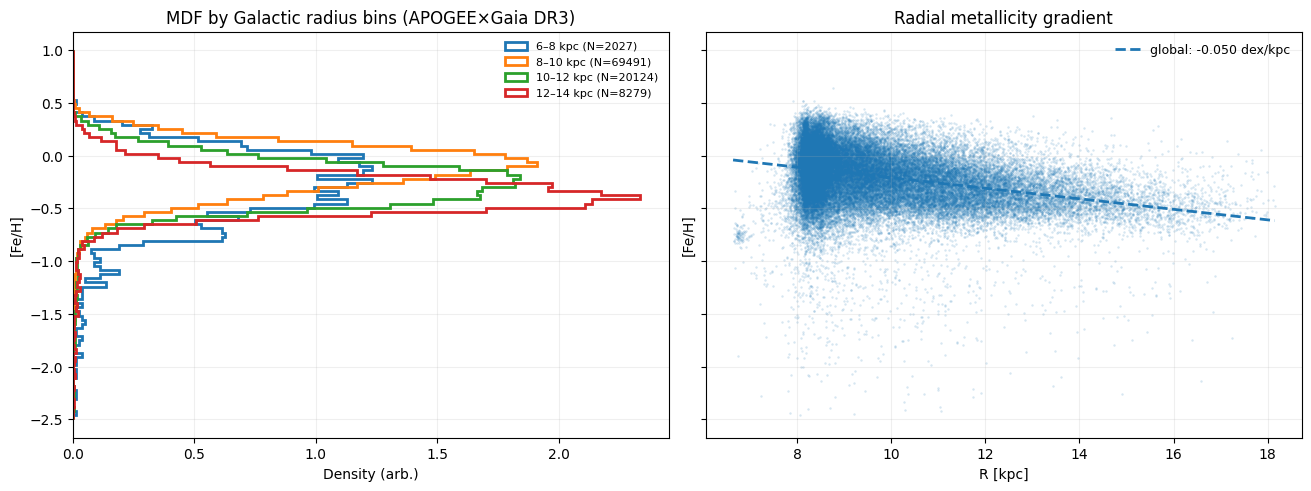

Global gradient d[Fe/H]/dR = -0.050 dex/kpc


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord, Galactocentric

# ---------------------------------
# Assumes `apogee` DataFrame exists from previous cell:
# columns: ra, dec, gaia_id, feh, plx_mas
# ---------------------------------

# --- Galactocentric frame constants ---
R0 = 8.2 * u.kpc
Z0 = 0.0208 * u.kpc

# ---------------------------------
# 1) Clean + distance estimate
# ---------------------------------
m = apogee.copy()

# ensure numeric
for col in ["ra", "dec", "feh", "plx_mas"]:
    m[col] = pd.to_numeric(m[col], errors="coerce")

m = m.dropna(subset=["ra", "dec", "feh", "plx_mas"]).copy()

# keep positive parallaxes only
m = m[m["plx_mas"] > 0].copy()

# rough distance (kpc) from parallax (mas): d[kpc] ~ 1 / plx[mas]
m["dist_kpc"] = 1.0 / m["plx_mas"]

# reasonable cuts (tune if needed)
m = m[(m["dist_kpc"] > 0.05) & (m["dist_kpc"] < 15.0)].copy()
m = m[(m["feh"] > -2.5) & (m["feh"] < 1.0)].copy()

print("Rows after parallax/dist/[FeH] cuts:", len(m))

# ---------------------------------
# 2) Convert to Galactocentric and compute R_gal
# ---------------------------------
c_icrs = SkyCoord(
    ra=m["ra"].to_numpy() * u.deg,
    dec=m["dec"].to_numpy() * u.deg,
    distance=m["dist_kpc"].to_numpy() * u.kpc,
    frame="icrs"
)

gc_frame = Galactocentric(galcen_distance=R0, z_sun=Z0)
c_galcen = c_icrs.transform_to(gc_frame)

x = c_galcen.x.to_value(u.kpc)
y = c_galcen.y.to_value(u.kpc)

m["R_gal"] = np.sqrt(x**2 + y**2)

# final sanity cut
m = m[(m["R_gal"] > 0) & (m["R_gal"] < 30)].copy()
print("Final rows with R_gal:", len(m))

# ---------------------------------
# 3) Plot: (b) MDF by R bins (rotated) and (c) R vs [Fe/H]
# ---------------------------------
fig, axes = plt.subplots(1, 2, figsize=(13, 4.8), constrained_layout=True, sharey=True)

# (b) MDF by radial bins — rotated (horizontal), [Fe/H] on Y axis
ax = axes[0]
feh_bins = np.linspace(-2.5, 1.0, 90)

radial_bins = [(4,6), (6,8), (8,10), (10,12), (12,14)]  # feel free to adjust
plotted_any = False

for r1, r2 in radial_bins:
    sel = (m["R_gal"] >= r1) & (m["R_gal"] < r2)
    n = int(sel.sum())
    if n < 1500:
        continue

    ax.hist(
        m.loc[sel, "feh"],
        bins=feh_bins,
        density=True,
        histtype="step",
        lw=2,
        orientation="horizontal",
        label=f"{r1}–{r2} kpc (N={n})"
    )
    plotted_any = True

ax.set_ylabel("[Fe/H]")
ax.set_xlabel("Density (arb.)")
ax.set_title("MDF by Galactic radius bins (APOGEE×Gaia DR3)")
ax.grid(alpha=0.2)

if plotted_any:
    ax.legend(frameon=False, fontsize=8)
else:
    ax.text(0.05, 0.95, "No bins with enough stars\n(try wider bins or lower N cut)",
            transform=ax.transAxes, va="top")

# (c) R vs [Fe/H]
ax = axes[1]
sample = m.sample(min(len(m), 60000), random_state=1)
ax.scatter(sample["R_gal"], sample["feh"], s=3, alpha=0.18, linewidths=0)

# linear fit (global gradient)
coef = np.polyfit(m["R_gal"].to_numpy(), m["feh"].to_numpy(), 1)
xfit = np.linspace(m["R_gal"].min(), m["R_gal"].max(), 300)
ax.plot(xfit, coef[0]*xfit + coef[1], lw=2, linestyle="--",
        label=f"global: {coef[0]:.3f} dex/kpc")

ax.set_xlabel("R [kpc]")
ax.set_ylabel("[Fe/H]")
ax.set_title("Radial metallicity gradient")
ax.grid(alpha=0.2)
ax.legend(frameon=False, fontsize=9)

plt.show()
print(f"Global gradient d[Fe/H]/dR = {coef[0]:.3f} dex/kpc")

### 1.2. Using Boulet+2024 Asteroseismic Ages

This section utilizes asteroseismic ages from Boulet et al. (2024) to study stellar evolution and Galactic chemical enrichment. These ages are derived from asteroseismic analysis of APOGEE stars and provide a more precise age estimation compared to the astroNN proxy used previously.

df_age rows: 125443


,age,age_err,feh,feh_err
0,5.77,1.27,-0.54,0.01
1,8.28,0.99,0.15,0.01
2,4.70,1.03,-0.24,0.01
3,8.60,1.03,-0.91,0.01
4,6.11,1.27,-0.04,0.01


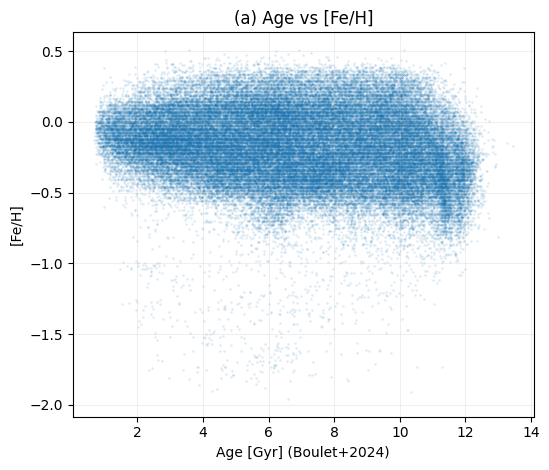

In [29]:
# --- LIGHT cell: get Age vs [Fe/H] quickly (Boulet+2024 calibrated APOGEE ages)
# Produces df_age (age[Gyr], feh) and plots panel (a).
# Optional: saves df_age to parquet for instant reload next time.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier

# --- Vizier setup (IMPORTANT: otherwise you may get only 50 rows)
Vizier.VIZIER_SERVER = "vizier.cds.unistra.fr"
Vizier.TIMEOUT = 120
Vizier.ROW_LIMIT = -1

viz = Vizier(columns=["Age", "e_Age", "[Fe/H]", "e_[Fe/H]"])
viz.ROW_LIMIT = -1

# Boulet+ 2024: asteroseismically calibrated ages for APOGEE DR17
# (VizieR table id may be exactly this; if your env errors, tell me the error text)
tab = viz.get_catalogs("J/A+A/685/A66/age_cat")[0].to_pandas()

df_age = (tab.rename(columns={"Age":"age", "e_Age":"age_err", "[Fe/H]":"feh", "e_[Fe/H]":"feh_err"})
            [["age","age_err","feh","feh_err"]])

# numeric + clean
for c in df_age.columns:
    df_age[c] = pd.to_numeric(df_age[c], errors="coerce")
df_age = df_age.dropna(subset=["age","feh"]).copy()

df_age = df_age[
    (df_age["age"] > 0) & (df_age["age"] < 14) &
    (df_age["feh"] > -2.0) & (df_age["feh"] < 1.0)
]

print("df_age rows:", len(df_age))
display(df_age.head())

# --- plot panel (a)
plt.figure(figsize=(5.6, 4.8))
samp = df_age.sample(min(len(df_age), 80000), random_state=1)  # enough for visuals
plt.scatter(samp["age"], samp["feh"], s=3, alpha=0.15, linewidths=0)
plt.xlabel("Age [Gyr] (Boulet+2024)")
plt.ylabel("[Fe/H]")
plt.title("(a) Age vs [Fe/H]")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# --- optional cache (uncomment if you want)
# df_age.to_parquet("df_age_boulet.parquet")
# print("Saved cache: df_age_boulet.parquet")

### 1.3. Evolution of [Fe/H] with Age and $r_{birth}$

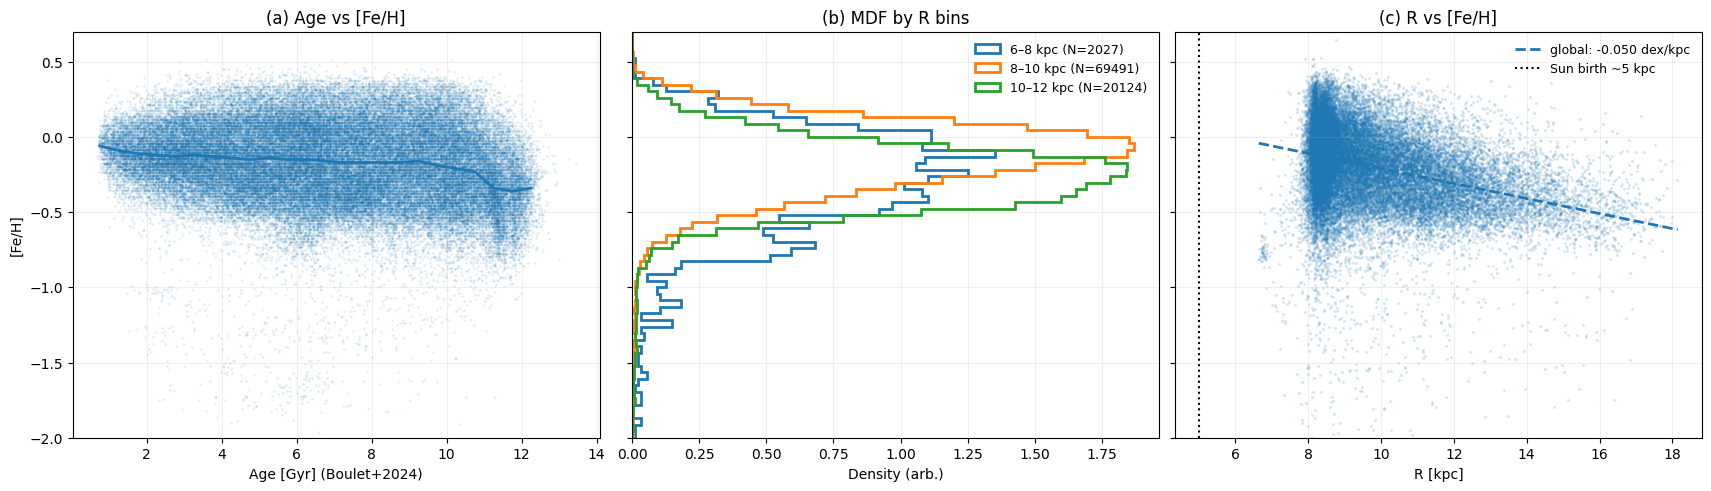

Global gradient d[Fe/H]/dR = -0.050 dex/kpc
Figure saved to: ../figures/en/Figure_2_2_MDF_Age_R_birth_gce_apogee_gaia.png


In [30]:
# --- POLISHED Figure (paper-style):
# sharey=True, unified [Fe/H] ticks, minimal Y labels, solar birth radius line

import numpy as np
import matplotlib.pyplot as plt
import os

# ---- checks
for col in ["age", "feh"]:
    assert col in df_age.columns, f"df_age missing {col}"
for col in ["R_gal", "feh"]:
    assert col in m.columns, f"m missing {col}"

# ---- helpers
def binned_median(x, y, bins, min_count=200):
    x = np.asarray(x); y = np.asarray(y)
    idx = np.digitize(x, bins) - 1
    xc, yc = [], []
    for i in range(len(bins)-1):
        sel = idx == i
        if sel.sum() < min_count:
            continue
        xc.append(0.5*(bins[i] + bins[i+1]))
        yc.append(np.nanmedian(y[sel]))
    return np.array(xc), np.array(yc)

# ---- shared styling
FEH_MIN, FEH_MAX = -2.0, 0.7
FEH_TICKS = np.arange(-2.0, 0.8, 0.5)
SOLAR_BIRTH_R = 5.0  # kpc (as in the paper narrative)

# ---- figure
fig, axes = plt.subplots(
    1, 3, figsize=(17, 4.8),
    constrained_layout=True, sharey=True
)

# =========================
# (a) Age vs [Fe/H]
# =========================
ax = axes[0]
samp_a = df_age.sample(min(len(df_age), 80000), random_state=1)
ax.scatter(samp_a["age"], samp_a["feh"], s=3, alpha=0.15, linewidths=0)

age_bins = np.linspace(0, 14, 29)  # 0.5 Gyr
xmed, ymed = binned_median(df_age["age"], df_age["feh"], age_bins, min_count=300)
if len(xmed) > 0:
    ax.plot(xmed, ymed, lw=2)

ax.set_xlabel("Age [Gyr] (Boulet+2024)")
ax.set_ylabel("[Fe/H]")
ax.set_title("(a) Age vs [Fe/H]")
ax.set_ylim(FEH_MIN, FEH_MAX)
ax.set_yticks(FEH_TICKS)
ax.grid(alpha=0.2)

# =========================
# (b) MDF rotated
# =========================
ax = axes[1]
feh_bins = np.linspace(FEH_MIN, 1.0, 70)
radial_bins = [(6,8), (8,10), (10,12)]

for r1, r2 in radial_bins:
    sel = (m["R_gal"] >= r1) & (m["R_gal"] < r2)
    if sel.sum() < 2000:
        continue
    ax.hist(
        m.loc[sel, "feh"],
        bins=feh_bins, density=True,
        histtype="step", lw=2,
        orientation="horizontal",
        label=f"{r1}–{r2} kpc (N={sel.sum()})"
    )

ax.set_xlabel("Density (arb.)")
ax.set_title("(b) MDF by R bins")
ax.set_ylim(FEH_MIN, FEH_MAX)
ax.set_yticks(FEH_TICKS)
ax.legend(frameon=False, fontsize=9)
ax.grid(alpha=0.2)

# =========================
# (c) R vs [Fe/H] + gradient + solar birth radius
# =========================
ax = axes[2]
samp_c = m.sample(min(len(m), 40000), random_state=1)
ax.scatter(samp_c["R_gal"], samp_c["feh"], s=4, alpha=0.2, linewidths=0)

coef = np.polyfit(m["R_gal"].values, m["feh"].values, 1)
xfit = np.linspace(m["R_gal"].min(), m["R_gal"].max(), 300)
ax.plot(xfit, coef[0]*xfit + coef[1], lw=2, linestyle="--",
        label=f"global: {coef[0]:.3f} dex/kpc")

# Solar birth radius marker
ax.axvline(SOLAR_BIRTH_R, color="k", lw=1.5, ls=":", label="Sun birth ~5 kpc")

ax.set_xlabel("R [kpc]")
ax.set_title("(c) R vs [Fe/H]")
ax.set_ylim(FEH_MIN, FEH_MAX)
ax.set_yticks(FEH_TICKS)
ax.legend(frameon=False, fontsize=9)
ax.grid(alpha=0.2)

# ---- remove duplicate Y labels on middle/right panels (paper-style)
axes[1].set_ylabel("")
axes[2].set_ylabel("")

plt.show()
print(f"Global gradient d[Fe/H]/dR = {coef[0]:.3f} dex/kpc")

def save_figure(fig, filename, dpi=300):
    """
    Save figure to figures/en with paper-ready settings.
    """
    outdir = os.path.join("../figures", "en")
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Figure saved to: {path}")

# ---- save (call after plotting)
save_figure(fig, "Figure_2_2_MDF_Age_R_birth_gce_apogee_gaia.png", dpi=300)

## What is `apogee` in this notebook?

In the current pipeline, **`apogee` is a `pandas.DataFrame`** held in memory.

### Data origin
- **Primary catalog:** APOGEE DR17  
- **Access method:** VizieR (`III/286/catalog`)
- **Astrometry:** Gaia DR3 (via CDS XMatch)

### How `apogee` is constructed
1. A large APOGEE sample is fetched from VizieR.
2. The table is cleaned to keep only stars with valid coordinates and metallicities.
3. The sample is **cross-matched with Gaia DR3** using the CDS XMatch service.
4. Only the columns required for the practical analysis are retained.

### Final structure of `apogee`
```text
apogee (pandas.DataFrame)
├─ ra        # Right ascension [deg] — from APOGEE/VizieR
├─ dec       # Declination [deg]     — from APOGEE/VizieR
├─ gaia_id   # Gaia DR3 source_id    — from CDS XMatch
├─ feh       # Stellar metallicity [Fe/H] — from APOGEE
└─ plx_mas   # Parallax [mas]        — from Gaia DR3

## 2. Graph metallicity vs r_birth for article

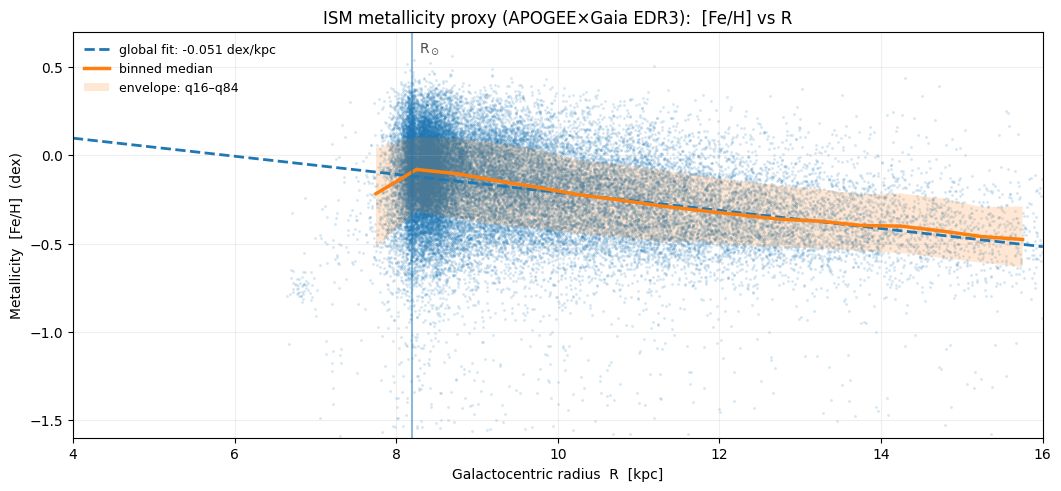

Global gradient d[Fe/H]/dR = -0.051 dex/kpc


In [31]:
# ---------------------------------
# 3) Plot: R vs [Fe/H] with binned trend + envelope
#     (single panel; remove the MDF panel)
# ---------------------------------
import numpy as np
import matplotlib.pyplot as plt

# --- optional: keep only a reasonable disk range for the figure ---
# (does NOT change your underlying dataframe m; only affects what we plot)
R_MIN, R_MAX = 4.0, 16.0
plot_df = m[(m["R_gal"] >= R_MIN) & (m["R_gal"] <= R_MAX)].copy()

fig, ax = plt.subplots(1, 1, figsize=(10.5, 4.8), constrained_layout=True)

# 1) Scatter (subsample for speed / clarity)
sample = plot_df.sample(min(len(plot_df), 40000), random_state=1)
ax.scatter(sample["R_gal"], sample["feh"], s=4, alpha=0.18, linewidths=0)

# 2) Global linear gradient (for reference)
coef = np.polyfit(plot_df["R_gal"].values, plot_df["feh"].values, 1)
xfit = np.linspace(R_MIN, R_MAX, 400)
ax.plot(xfit, coef[0]*xfit + coef[1], lw=2.0, linestyle="--",
        label=f"global fit: {coef[0]:.3f} dex/kpc")

# 3) Binned median + envelope (IQR or 1σ-like quantiles)
# Choose bins and quantiles
bin_w = 0.5  # kpc; adjust (0.25–1.0) for smoother/rougher envelope
bins = np.arange(R_MIN, R_MAX + bin_w, bin_w)
centers = 0.5 * (bins[:-1] + bins[1:])

q_lo, q_med, q_hi = 0.16, 0.50, 0.84   # ~1σ envelope
# Alternatively: 0.25/0.75 for IQR

med = np.full_like(centers, np.nan, dtype=float)
lo  = np.full_like(centers, np.nan, dtype=float)
hi  = np.full_like(centers, np.nan, dtype=float)
n_in_bin = np.zeros_like(centers, dtype=int)

R = plot_df["R_gal"].to_numpy()
F = plot_df["feh"].to_numpy()

for i in range(len(centers)):
    sel = (R >= bins[i]) & (R < bins[i+1])
    n = int(sel.sum())
    n_in_bin[i] = n
    if n < 200:  # skip sparse bins to avoid noisy quantiles
        continue
    vals = F[sel]
    lo[i], med[i], hi[i] = np.quantile(vals, [q_lo, q_med, q_hi])

# Plot median trend
ax.plot(centers, med, lw=2.5, label="binned median")

# Plot envelope as a filled band
ax.fill_between(centers, lo, hi, alpha=0.18, linewidth=0,
                label=f"envelope: q{int(q_lo*100)}–q{int(q_hi*100)}")

# 4) Axis styling + useful reference marks
ax.set_xlim(R_MIN, R_MAX)
ax.set_ylim(-1.6, 0.7)  # adjust as you like
ax.set_xlabel("Galactocentric radius  R  [kpc]")
ax.set_ylabel("Metallicity  [Fe/H]  (dex)")
ax.set_title("ISM metallicity proxy (APOGEE×Gaia EDR3):  [Fe/H] vs R")

# Mark solar radius if you want it visually
ax.axvline(R0.to_value(u.kpc), lw=1.5, alpha=0.5)
ax.text(R0.to_value(u.kpc)+0.08, ax.get_ylim()[1]-0.05, "R$_\\odot$",
        va="top", fontsize=10, alpha=0.7)

ax.grid(alpha=0.2)
ax.legend(frameon=False, fontsize=9)

plt.show()
print(f"Global gradient d[Fe/H]/dR = {coef[0]:.3f} dex/kpc")

In [34]:
# =========================================================
# Save APOGEE × Gaia dataframe for animation notebooks
# =========================================================

from pathlib import Path

# --- guard ---
if "m" not in globals():
    raise RuntimeError("DataFrame `m` not found. Run the data construction cells first.")

# --- paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
out_dir = topic_root / "data/processed"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "apogee_gaia_fehr_R.csv"

# --- select only what is needed downstream ---
cols = ["ra", "dec", "gaia_id", "feh", "plx_mas", "dist_kpc", "R_gal"]
available = [c for c in cols if c in m.columns]

m_out = m[available].copy()

# --- save ---
m_out.to_csv(out_path, index=False)

print("Saved APOGEE×Gaia dataframe for animations:")
print("Path :", out_path)
print("Rows :", len(m_out))
print("Cols :", list(m_out.columns))

Saved APOGEE×Gaia dataframe for animations:
Path : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/apogee_gaia_fehr_R.csv
Rows : 103380
Cols : ['ra', 'dec', 'gaia_id', 'feh', 'plx_mas', 'dist_kpc', 'R_gal']


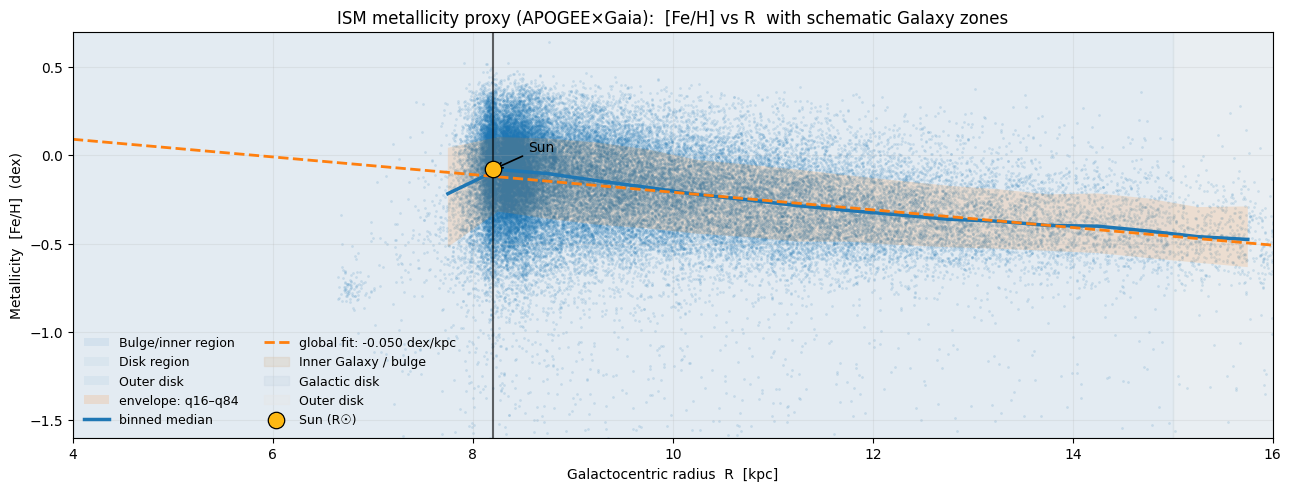

Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_X_ISM_proxy_with_zones.png


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from lulab.io.save_figure import save_fig


# =========================================================
# Plot: [Fe/H] vs R with schematic Galaxy zones + Sun marker
# Expects a DataFrame `m` with columns: R_gal, feh
# and (optionally) arrays for binned median already computed
# =========================================================

if "m" not in globals():
    raise RuntimeError("DataFrame `m` not found. Load it first (apogee_gaia_fehr_R.csv or build pipeline).")

# --- choose columns ---
R = m["R_gal"].to_numpy()
FeH = m["feh"].to_numpy()

# --- plot range (keep consistent with your previous figure) ---
x_min, x_max = 4.0, 16.0
y_min, y_max = -1.6, 0.7

# --- schematic "profile" zones along R (kpc) ---
# tweak these edges if you want
R_BULGE_MAX = 3.0
R_THIN_START = 3.0
R_THIN_END = 15.0

R_SUN = 8.2  # kpc

# --- make binned trend (median + 16-84 envelope) ---
bins = np.arange(7.5, 16.01, 0.5)  # same idea as your current plot
cent = 0.5 * (bins[:-1] + bins[1:])

med = np.full_like(cent, np.nan, dtype=float)
p16 = np.full_like(cent, np.nan, dtype=float)
p84 = np.full_like(cent, np.nan, dtype=float)

for i in range(len(cent)):
    sel = (R >= bins[i]) & (R < bins[i+1])
    if sel.sum() < 50:
        continue
    vals = FeH[sel]
    med[i] = np.nanmedian(vals)
    p16[i] = np.nanpercentile(vals, 16)
    p84[i] = np.nanpercentile(vals, 84)

# --- global fit (optional, like before) ---
coef = np.polyfit(R[np.isfinite(R) & np.isfinite(FeH)], FeH[np.isfinite(R) & np.isfinite(FeH)], 1)
xfit = np.linspace(x_min, x_max, 200)
yfit = coef[0]*xfit + coef[1]

# --- find Sun point on the median curve (nearest bin center) ---
i_sun = int(np.nanargmin(np.abs(cent - R_SUN)))
sun_feh = med[i_sun] if np.isfinite(med[i_sun]) else (coef[0]*R_SUN + coef[1])

# =========================================================
# Plot
# =========================================================
fig, ax = plt.subplots(figsize=(12.8, 4.8), constrained_layout=True)

# --- Galaxy zones (schematic, very light) ---
# Inner/bulge
ax.axvspan(x_min, min(R_BULGE_MAX, x_max), alpha=0.08, label="Bulge/inner region")

# Thin disk dominant region
ax.axvspan(max(R_THIN_START, x_min), min(R_THIN_END, x_max), alpha=0.05, label="Disk region")

# Outer disk (if visible)
if x_max > R_THIN_END:
    ax.axvspan(R_THIN_END, x_max, alpha=0.06, label="Outer disk")

# --- scatter cloud ---
# (keep light; sample if needed)
N_MAX = 60000
if len(m) > N_MAX:
    samp = m.sample(N_MAX, random_state=1)
    ax.scatter(samp["R_gal"], samp["feh"], s=4, alpha=0.15, linewidths=0)
else:
    ax.scatter(R, FeH, s=4, alpha=0.15, linewidths=0)

# --- envelope + median trend ---
ax.fill_between(cent, p16, p84, alpha=0.15, label="envelope: q16–q84")
ax.plot(cent, med, lw=2.5, label="binned median")

# --- global fit ---
ax.plot(xfit, yfit, lw=2, ls="--", label=f"global fit: {coef[0]:.3f} dex/kpc")

# --- Galaxy zones (schematic, stronger contrast) ---

# Inner Galaxy / bulge-bar region
ax.axvspan(
    x_min, min(R_BULGE_MAX, x_max),
    color="#d9c6b0", alpha=0.35, zorder=0,
    label="Inner Galaxy / bulge"
)

# Thin disk dominant region
ax.axvspan(
    max(R_THIN_START, x_min), min(R_THIN_END, x_max),
    color="#c7d4e2", alpha=0.30, zorder=0,
    label="Galactic disk"
)

# Outer disk (if visible)
if x_max > R_THIN_END:
    ax.axvspan(
        R_THIN_END, x_max,
        color="#e6e6e6", alpha=0.35, zorder=0,
        label="Outer disk"
    )
# --- Solar circle line + Sun marker ---
ax.axvline(R_SUN, lw=1.5, color="k", alpha=0.6)

ax.scatter(
    [R_SUN], [sun_feh],
    s=140,
    color="#FDB813",      # солнечный жёлтый
    edgecolor="k",
    linewidth=0.9,
    zorder=10,
    label="Sun (R\u2609)"
)

# Optional annotation
ax.annotate(
    "Sun",
    xy=(R_SUN, sun_feh),
    xytext=(R_SUN + 0.35, sun_feh + 0.10),
    arrowprops=dict(arrowstyle="->", lw=1.2),
    fontsize=10,
    ha="left"
)

# --- cosmetics ---
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("Galactocentric radius  R  [kpc]")
ax.set_ylabel("Metallicity  [Fe/H]  (dex)")
ax.set_title("ISM metallicity proxy (APOGEE×Gaia):  [Fe/H] vs R  with schematic Galaxy zones")
ax.grid(alpha=0.2)

# keep legend readable
ax.legend(frameon=False, fontsize=9, ncols=2)

plt.show()

# If you use your save_fig helper:
save_fig("Figure_X_ISM_proxy_with_zones", fig)

Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_X_ISM_proxy_galaxy_overlay_dualY.png


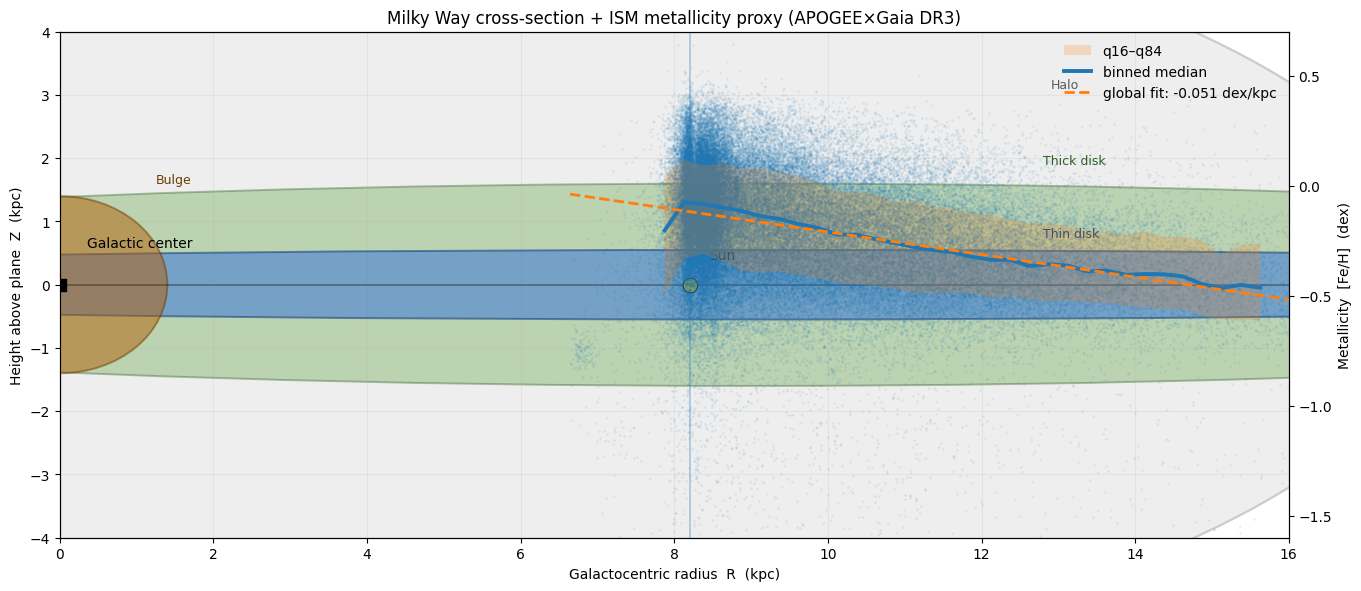

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

# -------------------------------------------------
# Expected:
#   m : DataFrame with columns ["R_gal", "feh"] at least
# Optional:
#   save_fig(name, fig)
# -------------------------------------------------

# ==== config ====
R0 = 8.2          # Sun galactocentric radius [kpc]
R_MIN, R_MAX = 0.0, 16.0

# scatter sampling
N_SCAT = 120_000

# bins for median/envelope
R_BINS = np.arange(R_MIN, R_MAX + 0.25, 0.25)
R_CENT = 0.5 * (R_BINS[:-1] + R_BINS[1:])

# appearance
SHOW_SCATTER = True
SHOW_GLOBAL_FIT = True

# ==== data ====
df = m.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] >= R_MIN) & (df["R_gal"] <= R_MAX)]
df = df[(df["feh"] > -2.5) & (df["feh"] < 1.0)]

# binned stats
med = np.full_like(R_CENT, np.nan, dtype=float)
q16 = np.full_like(R_CENT, np.nan, dtype=float)
q84 = np.full_like(R_CENT, np.nan, dtype=float)
cnt = np.zeros_like(R_CENT, dtype=int)

for i in range(len(R_CENT)):
    sel = (df["R_gal"].values >= R_BINS[i]) & (df["R_gal"].values < R_BINS[i+1])
    cnt[i] = int(sel.sum())
    if cnt[i] >= 200:
        v = df.loc[sel, "feh"].values
        med[i] = np.nanmedian(v)
        q16[i] = np.nanpercentile(v, 16)
        q84[i] = np.nanpercentile(v, 84)

ok = np.isfinite(med)

# sample for scatter
scat = df.sample(min(len(df), N_SCAT), random_state=1) if SHOW_SCATTER else None

# =================================================
# Single combined plot:
#   - X: R (kpc)
#   - Left Y: Z (kpc) for galaxy cross-section background
#   - Right Y: [Fe/H] for the metallicity curve/scatter
# =================================================
fig, axZ = plt.subplots(figsize=(13.5, 5.8), constrained_layout=True)

# ---- Left axis: Galaxy cross-section in (R,Z) ----
axZ.set_xlim(R_MIN, R_MAX)
axZ.set_ylim(-4.0, 4.0)
axZ.set_xlabel("Galactocentric radius  R  (kpc)")
axZ.set_ylabel("Height above plane  Z  (kpc)")
axZ.grid(alpha=0.18)

# Make background patches clearly visible on white
# Halo
halo = Ellipse(
    xy=(0, 0),
    width=2 * 18.0, height=2 * 7.0,
    facecolor="0.80", edgecolor="0.45", lw=1.6, alpha=0.32, zorder=0
)
axZ.add_patch(halo)

# Thick disk
thick = Ellipse(
    xy=(9.0, 0),
    width=2 * 18.0, height=2 * 1.6,
    facecolor="#6AA84F", edgecolor="#2F5E22", lw=1.4, alpha=0.38, zorder=1
)
axZ.add_patch(thick)

# Thin disk
thin = Ellipse(
    xy=(9.0, 0),
    width=2 * 18.0, height=2 * 0.55,
    facecolor="#3C78D8", edgecolor="#123A7A", lw=1.4, alpha=0.55, zorder=2
)
axZ.add_patch(thin)

# Bulge
bulge = Circle(
    xy=(0, 0), radius=1.4,
    facecolor="#B45F06", edgecolor="#6E3B00", lw=1.4, alpha=0.50, zorder=3
)
axZ.add_patch(bulge)

# Midplane (disk symmetry axis) = X axis
axZ.axhline(0, color="k", lw=1.2, alpha=0.35, zorder=10)

# Galactic center marker at (0,0)
axZ.scatter([0], [0], s=70, marker="s", color="k", zorder=11)
axZ.text(0.35, 0.55, "Galactic center", fontsize=10, va="bottom", zorder=12)

# Sun marker in the plane (Z=0) at R0
axZ.scatter([R0], [0], s=110, marker="o", edgecolor="k", linewidth=0.7,
            color="#FFD400", zorder=12)
axZ.text(R0 + 0.25, 0.35, "Sun", fontsize=10, va="bottom", zorder=12)

# Keep solar radius line
axZ.axvline(R0, lw=1.2, alpha=0.35, zorder=9)

# Labels (optional)
axZ.text(12.9, 3.1, "Halo", fontsize=9, color="0.35")
axZ.text(12.8, 1.9, "Thick disk", fontsize=9, color="#2F5E22")
axZ.text(12.8, 0.75, "Thin disk", fontsize=9, color="#123A7A")
axZ.text(1.25, 1.6, "Bulge", fontsize=9, color="#6E3B00")

# ---- Right axis: [Fe/H] on top of same X ----
axF = axZ.twinx()
axF.set_ylabel("Metallicity  [Fe/H]  (dex)")
axF.set_ylim(-1.6, 0.7)

# scatter
if SHOW_SCATTER and scat is not None:
    axF.scatter(scat["R_gal"], scat["feh"], s=3, alpha=0.12, linewidths=0, zorder=20)

# envelope + median
axF.fill_between(R_CENT[ok], q16[ok], q84[ok], alpha=0.22, zorder=21, label="q16–q84")
axF.plot(R_CENT[ok], med[ok], lw=2.8, zorder=22, label="binned median")

# optional global fit
if SHOW_GLOBAL_FIT:
    coef = np.polyfit(df["R_gal"].values, df["feh"].values, 1)
    xline = np.linspace(df["R_gal"].min(), df["R_gal"].max(), 200)
    axF.plot(xline, coef[0]*xline + coef[1], lw=2.0, ls="--", zorder=23,
             label=f"global fit: {coef[0]:+.3f} dex/kpc")

# Title
axZ.set_title("Milky Way cross-section + ISM metallicity proxy (APOGEE×Gaia DR3)")

# Legend (use right-axis artists)
axF.legend(frameon=False, loc="upper right")

# Save
try:
    save_fig("Figure_X_ISM_proxy_galaxy_overlay_dualY", fig)
except NameError:
    pass

plt.show()

Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_X_ISM_proxy_galaxy_overlay_colorbar.png


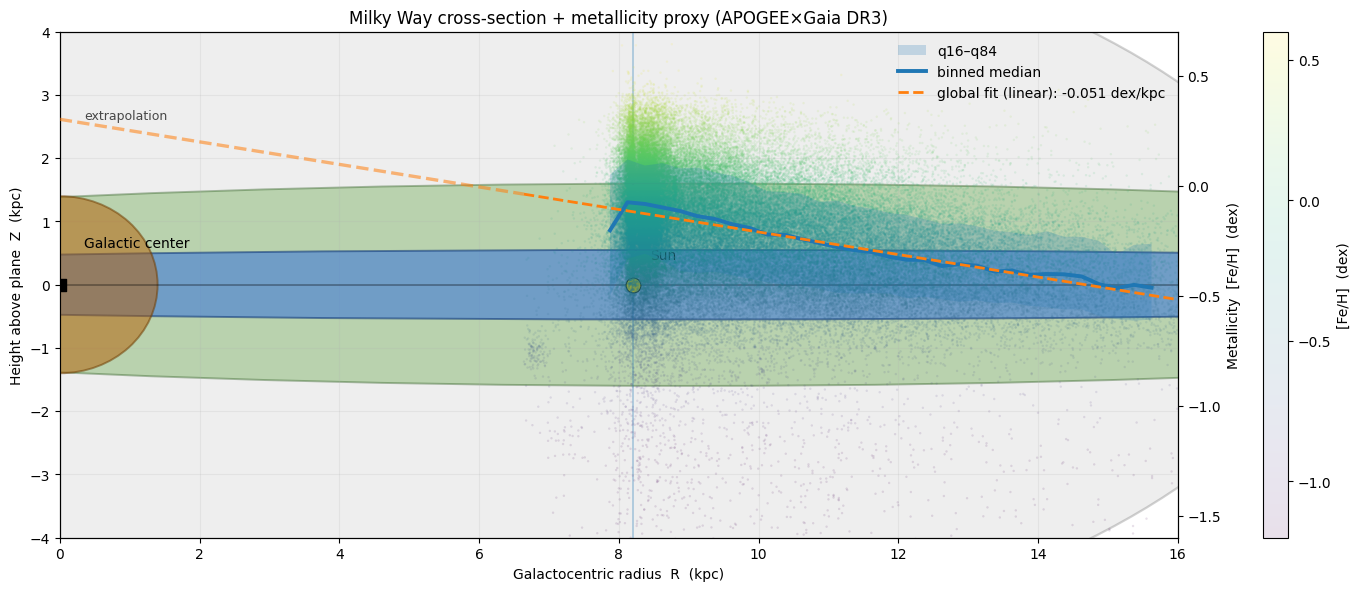

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

# -------------------------------------------------
# Expected:
#   m : DataFrame with columns ["R_gal", "feh"] at least
# Optional:
#   save_fig(name, fig)
# -------------------------------------------------

# ==== config ====
R0 = 8.2          # Sun galactocentric radius [kpc]
R_MIN, R_MAX = 0.0, 16.0

# scatter sampling
N_SCAT = 120_000
SHOW_SCATTER = True

# median/envelope bins
R_BINS = np.arange(R_MIN, R_MAX + 0.25, 0.25)
R_CENT = 0.5 * (R_BINS[:-1] + R_BINS[1:])

# colorbar/scatter styling
CMAP = "viridis"
FEH_VMIN, FEH_VMAX = -1.2, 0.6   # clamp for nicer colors (tweak if needed)
SCAT_S = 3
SCAT_ALPHA = 0.12

# fits
SHOW_GLOBAL_FIT = True
EXTRAPOLATE_TO_CENTER = True
EXTRAP_METHOD = "linear"   # "linear" or "quadratic"
EXTRAP_STYLE = dict(ls="--", lw=2.4, alpha=0.55)

# ==== data ====
df = m.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] >= R_MIN) & (df["R_gal"] <= R_MAX)]
df = df[(df["feh"] > -2.5) & (df["feh"] < 1.0)]

# binned stats
med = np.full_like(R_CENT, np.nan, dtype=float)
q16 = np.full_like(R_CENT, np.nan, dtype=float)
q84 = np.full_like(R_CENT, np.nan, dtype=float)
cnt = np.zeros_like(R_CENT, dtype=int)

for i in range(len(R_CENT)):
    sel = (df["R_gal"].values >= R_BINS[i]) & (df["R_gal"].values < R_BINS[i+1])
    cnt[i] = int(sel.sum())
    if cnt[i] >= 200:
        v = df.loc[sel, "feh"].values
        med[i] = np.nanmedian(v)
        q16[i] = np.nanpercentile(v, 16)
        q84[i] = np.nanpercentile(v, 84)

ok = np.isfinite(med)

# sample for scatter
scat = df.sample(min(len(df), N_SCAT), random_state=1) if SHOW_SCATTER else None


# =================================================
# Combined plot:
#   X: R (kpc)
#   Left Y: Z (kpc) galaxy cross-section
#   Right Y: [Fe/H] series
#   Colorbar: [Fe/H] for scatter gradient
# =================================================
fig, axZ = plt.subplots(figsize=(13.5, 5.8), constrained_layout=True)

# ---- Left axis: Galaxy cross-section in (R,Z) ----
axZ.set_xlim(R_MIN, R_MAX)
axZ.set_ylim(-4.0, 4.0)
axZ.set_xlabel("Galactocentric radius  R  (kpc)")
axZ.set_ylabel("Height above plane  Z  (kpc)")
axZ.grid(alpha=0.18)

# Background patches (darker/denser so visible on white)
halo = Ellipse((0, 0), width=2*18.0, height=2*7.0,
               facecolor="0.80", edgecolor="0.45", lw=1.6, alpha=0.32, zorder=0)
axZ.add_patch(halo)

thick = Ellipse((9.0, 0), width=2*18.0, height=2*1.6,
                facecolor="#6AA84F", edgecolor="#2F5E22", lw=1.4, alpha=0.40, zorder=1)
axZ.add_patch(thick)

thin = Ellipse((9.0, 0), width=2*18.0, height=2*0.55,
               facecolor="#3C78D8", edgecolor="#123A7A", lw=1.4, alpha=0.58, zorder=2)
axZ.add_patch(thin)

bulge = Circle((0, 0), radius=1.4,
               facecolor="#B45F06", edgecolor="#6E3B00", lw=1.4, alpha=0.52, zorder=3)
axZ.add_patch(bulge)

axZ.axhline(0, color="k", lw=1.2, alpha=0.35, zorder=10)

# GC + Sun
axZ.scatter([0], [0], s=70, marker="s", color="k", zorder=11)
axZ.text(0.35, 0.55, "Galactic center", fontsize=10, va="bottom", zorder=12)

axZ.scatter([R0], [0], s=115, marker="o", edgecolor="k", linewidth=0.7,
            color="#FFD400", zorder=12)
axZ.text(R0 + 0.25, 0.35, "Sun", fontsize=10, va="bottom", zorder=12)
axZ.axvline(R0, lw=1.2, alpha=0.35, zorder=9)

# ---- Right axis: [Fe/H] curves + colored scatter ----
axF = axZ.twinx()
axF.set_ylabel("Metallicity  [Fe/H]  (dex)")
axF.set_ylim(-1.6, 0.7)

mappable = None
if SHOW_SCATTER and scat is not None:
    # Color scatter by [Fe/H] and show colorbar
    mappable = axF.scatter(
        scat["R_gal"], scat["feh"],
        c=scat["feh"], cmap=CMAP, vmin=FEH_VMIN, vmax=FEH_VMAX,
        s=SCAT_S, alpha=SCAT_ALPHA, linewidths=0, zorder=20
    )

# envelope + median (solid only where data exists)
axF.fill_between(R_CENT[ok], q16[ok], q84[ok], alpha=0.22, zorder=21, label="q16–q84")
axF.plot(R_CENT[ok], med[ok], lw=2.8, zorder=22, label="binned median")

# optional global fit + (optional) extrapolation to center
if SHOW_GLOBAL_FIT:
    x = df["R_gal"].values
    y = df["feh"].values

    deg = 1 if EXTRAP_METHOD == "linear" else 2
    coef = np.polyfit(x, y, deg)

    x_in = np.linspace(x.min(), x.max(), 250)
    y_in = np.polyval(coef, x_in)
    axF.plot(x_in, y_in, lw=2.0, ls="--", zorder=23,
             label=f"global fit ({EXTRAP_METHOD}): {coef[0]:+.3f} dex/kpc" if deg == 1 else "global fit (quadratic)")

    if EXTRAPOLATE_TO_CENTER:
        # extrapolate only into the "missing" inner region, show as lighter dashed line
        x_ex = np.linspace(R_MIN, x.min(), 180)
        y_ex = np.polyval(coef, x_ex)
        axF.plot(x_ex, y_ex, color=axF.lines[-1].get_color(), zorder=23, **EXTRAP_STYLE)
        axF.text(0.35, np.clip(y_ex[0], -1.5, 0.6),
                 "extrapolation", fontsize=9, alpha=0.7)

# Title + legend
axZ.set_title("Milky Way cross-section + metallicity proxy (APOGEE×Gaia DR3)")
axF.legend(frameon=False, loc="upper right")

# ---- Colorbar on the right (nice “gradient” look) ----
if mappable is not None:
    cbar = fig.colorbar(mappable, ax=axF, pad=0.02, fraction=0.045)
    cbar.set_label("[Fe/H]  (dex)")
    # Optional: show a few ticks
    cbar.set_ticks([-1.0, -0.5, 0.0, 0.5])

# Save
try:
    save_fig("Figure_X_ISM_proxy_galaxy_overlay_colorbar", fig)
except NameError:
    pass

plt.show()

Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_X_ISM_proxy_galaxy_overlay_heatmap.png


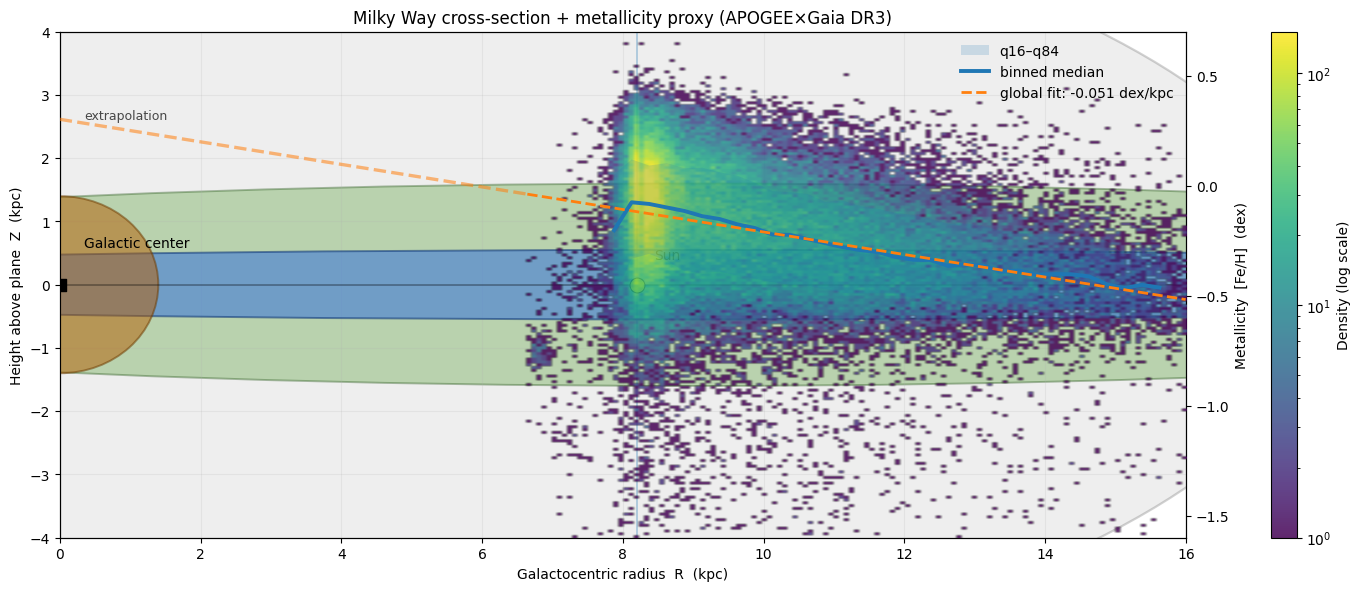

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from matplotlib.colors import LogNorm

# -------------------------------------------------
# Expected:
#   m : DataFrame with columns ["R_gal", "feh"]
# Optional:
#   save_fig(name, fig)
# -------------------------------------------------

# ==== config ====
R0 = 8.2          # Sun galactocentric radius [kpc]
R_MIN, R_MAX = 0.0, 16.0

# heatmap binning
R_NBINS   = 220
FEH_MIN, FEH_MAX = -1.6, 0.7
FEH_NBINS = 180

# heatmap style
USE_LOG_NORM = True            # LogNorm makes structure pop
HEATMAP_ALPHA = 0.85
CMAP = "viridis"

# binned stats (for median/envelope)
R_BINS = np.arange(R_MIN, R_MAX + 0.25, 0.25)
R_CENT = 0.5 * (R_BINS[:-1] + R_BINS[1:])

# fits
SHOW_GLOBAL_FIT = True
EXTRAPOLATE_TO_CENTER = True
EXTRAP_METHOD = "linear"   # "linear" or "quadratic"
EXTRAP_STYLE = dict(ls="--", lw=2.4, alpha=0.55)

# ==== data ====
df = m.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] >= R_MIN) & (df["R_gal"] <= R_MAX)]
df = df[(df["feh"] > -2.5) & (df["feh"] < 1.0)]

R = df["R_gal"].to_numpy(dtype=float)
F = df["feh"].to_numpy(dtype=float)

# ==== binned median/envelope (1D in R) ====
med = np.full_like(R_CENT, np.nan, dtype=float)
q16 = np.full_like(R_CENT, np.nan, dtype=float)
q84 = np.full_like(R_CENT, np.nan, dtype=float)
cnt = np.zeros_like(R_CENT, dtype=int)

for i in range(len(R_CENT)):
    sel = (R >= R_BINS[i]) & (R < R_BINS[i+1])
    cnt[i] = int(sel.sum())
    if cnt[i] >= 200:
        v = F[sel]
        med[i] = np.nanmedian(v)
        q16[i] = np.nanpercentile(v, 16)
        q84[i] = np.nanpercentile(v, 84)

ok = np.isfinite(med)

# ==== 2D histogram for heatmap (R vs [Fe/H]) ====
xedges = np.linspace(R_MIN, R_MAX, R_NBINS + 1)
yedges = np.linspace(FEH_MIN, FEH_MAX, FEH_NBINS + 1)
H, _, _ = np.histogram2d(R, F, bins=(xedges, yedges))

# transpose for imshow: rows->y, cols->x
H = H.T

# avoid issues with LogNorm on zeros
if USE_LOG_NORM:
    # set zeros to NaN so they stay transparent-ish if alpha < 1
    H_plot = H.copy()
    H_plot[H_plot <= 0] = np.nan
    norm = LogNorm(vmin=np.nanpercentile(H_plot, 5), vmax=np.nanpercentile(H_plot, 99.5))
else:
    H_plot = H
    norm = None

# =================================================
# Combined plot:
#   X: R (kpc)
#   Left Y: Z (kpc) galaxy cross-section
#   Right Y: [Fe/H] + heatmap + curves
# =================================================
fig, axZ = plt.subplots(figsize=(13.5, 5.8), constrained_layout=True)

# ---- Left axis: Galaxy cross-section in (R,Z) ----
axZ.set_xlim(R_MIN, R_MAX)
axZ.set_ylim(-4.0, 4.0)
axZ.set_xlabel("Galactocentric radius  R  (kpc)")
axZ.set_ylabel("Height above plane  Z  (kpc)")
axZ.grid(alpha=0.18)

# Background patches (make visible on white)
halo = Ellipse((0, 0), width=2*18.0, height=2*7.0,
               facecolor="0.80", edgecolor="0.45", lw=1.6, alpha=0.32, zorder=0)
axZ.add_patch(halo)

thick = Ellipse((9.0, 0), width=2*18.0, height=2*1.6,
                facecolor="#6AA84F", edgecolor="#2F5E22", lw=1.4, alpha=0.40, zorder=1)
axZ.add_patch(thick)

thin = Ellipse((9.0, 0), width=2*18.0, height=2*0.55,
               facecolor="#3C78D8", edgecolor="#123A7A", lw=1.4, alpha=0.58, zorder=2)
axZ.add_patch(thin)

bulge = Circle((0, 0), radius=1.4,
               facecolor="#B45F06", edgecolor="#6E3B00", lw=1.4, alpha=0.52, zorder=3)
axZ.add_patch(bulge)

axZ.axhline(0, color="k", lw=1.2, alpha=0.35, zorder=10)
axZ.axvline(R0, lw=1.2, alpha=0.35, zorder=9)

# GC + Sun
axZ.scatter([0], [0], s=70, marker="s", color="k", zorder=11)
axZ.text(0.35, 0.55, "Galactic center", fontsize=10, va="bottom", zorder=12)

axZ.scatter([R0], [0], s=115, marker="o", edgecolor="k", linewidth=0.7,
            color="#FFD400", zorder=12)
axZ.text(R0 + 0.25, 0.35, "Sun", fontsize=10, va="bottom", zorder=12)

# ---- Right axis: [Fe/H] heatmap + curves ----
axF = axZ.twinx()
axF.set_ylabel("Metallicity  [Fe/H]  (dex)")
axF.set_ylim(FEH_MIN, FEH_MAX)

# Heatmap as an "image" aligned to axes extents
im = axF.imshow(
    H_plot,
    origin="lower",
    aspect="auto",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap=CMAP,
    norm=norm,
    alpha=HEATMAP_ALPHA,
    zorder=20
)

# Median + envelope
axF.fill_between(R_CENT[ok], q16[ok], q84[ok], alpha=0.18, zorder=21, label="q16–q84")
axF.plot(R_CENT[ok], med[ok], lw=2.8, zorder=22, label="binned median")

# Global fit + optional extrapolation
if SHOW_GLOBAL_FIT:
    deg = 1 if EXTRAP_METHOD == "linear" else 2
    coef = np.polyfit(R, F, deg)

    x_in = np.linspace(R.min(), R.max(), 250)
    y_in = np.polyval(coef, x_in)
    axF.plot(
        x_in, y_in,
        lw=2.0, ls="--", zorder=23,
        label=f"global fit ({EXTRAP_METHOD})" if deg != 1 else f"global fit: {coef[0]:+.3f} dex/kpc"
    )

    if EXTRAPOLATE_TO_CENTER:
        x_ex = np.linspace(R_MIN, R.min(), 200)
        y_ex = np.polyval(coef, x_ex)
        axF.plot(x_ex, y_ex, color=axF.lines[-1].get_color(), zorder=23, **EXTRAP_STYLE)
        axF.text(0.35, np.clip(y_ex[0], FEH_MIN + 0.1, FEH_MAX - 0.1),
                 "extrapolation", fontsize=9, alpha=0.7)

# Legends / title
axZ.set_title("Milky Way cross-section + metallicity proxy (APOGEE×Gaia DR3)")
axF.legend(frameon=False, loc="upper right")

# Colorbar (density scale)
cbar = fig.colorbar(im, ax=axF, pad=0.02, fraction=0.045)
cbar.set_label("Density (stars per bin)")
if USE_LOG_NORM:
    cbar.set_label("Density (log scale)")

# Save
try:
    save_fig("Figure_X_ISM_proxy_galaxy_overlay_heatmap", fig)
except NameError:
    pass

plt.show()

Rows for diagnostics: 103380
Bins: 40
Bins with N >= 400: 17
Min/Max N in bins: 0 33738


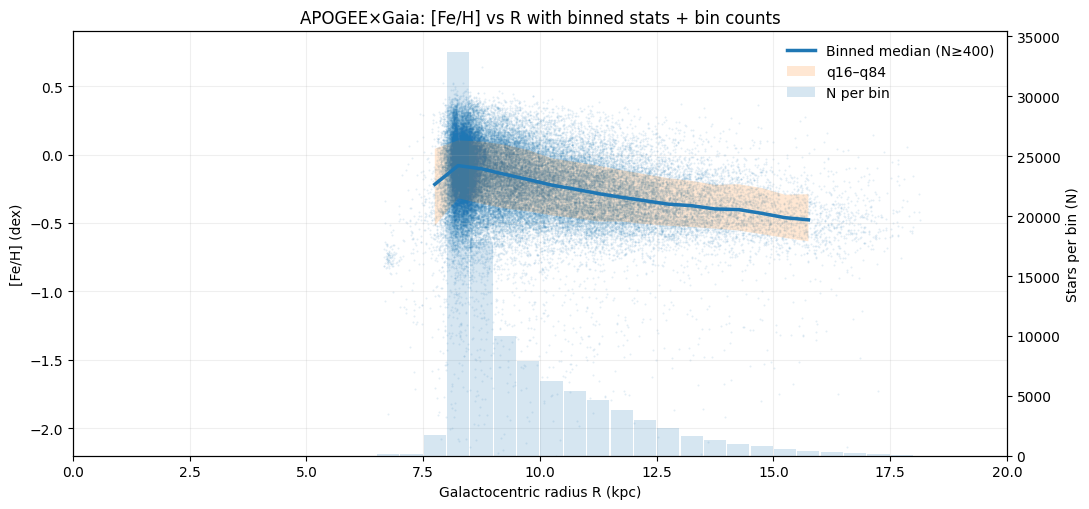

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Input: dataframe with R_gal and feh
# ----------------------------
# change this line if your dataframe has a different name
df = m.copy()

# robust column pick
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

R_col   = pick_col(df, ["R_gal", "R", "rgc", "Rgc"])
feh_col = pick_col(df, ["feh", "[Fe/H]", "FE_H", "fe_h", "mh", "metallicity"])

if R_col is None or feh_col is None:
    raise RuntimeError(f"Need columns for R and [Fe/H]. Found columns: {list(df.columns)[:30]} ...")

# clean
df = df[[R_col, feh_col]].rename(columns={R_col:"R_gal", feh_col:"feh"}).copy()
df["R_gal"] = pd.to_numeric(df["R_gal"], errors="coerce")
df["feh"]   = pd.to_numeric(df["feh"],   errors="coerce")
df = df.dropna(subset=["R_gal","feh"])
df = df[(df["R_gal"] > 0) & (df["R_gal"] < 30) & (df["feh"] > -3) & (df["feh"] < 1.5)]

print("Rows for diagnostics:", len(df))

# ----------------------------
# Binning config
# ----------------------------
R_MIN, R_MAX = 0.0, 20.0
BIN_W = 0.5                      # kpc
MIN_N = 400                      # draw median only if >= MIN_N (tune: 200/400/800)

bins = np.arange(R_MIN, R_MAX + BIN_W, BIN_W)
cent = 0.5 * (bins[:-1] + bins[1:])

# ----------------------------
# Compute binned stats
# ----------------------------
idx = np.digitize(df["R_gal"].values, bins) - 1
valid = (idx >= 0) & (idx < len(cent))
idx = idx[valid]
feh = df["feh"].values[valid]

N   = np.bincount(idx, minlength=len(cent)).astype(int)

med = np.full(len(cent), np.nan, dtype=float)
q16 = np.full(len(cent), np.nan, dtype=float)
q84 = np.full(len(cent), np.nan, dtype=float)

# compute quantiles per bin
for i in range(len(cent)):
    if N[i] == 0:
        continue
    vals = feh[idx == i]
    med[i] = np.nanmedian(vals)
    q16[i] = np.nanpercentile(vals, 16)
    q84[i] = np.nanpercentile(vals, 84)

mask = N >= MIN_N

print("Bins:", len(cent))
print(f"Bins with N >= {MIN_N}:", int(mask.sum()))
print("Min/Max N in bins:", int(N.min()), int(N.max()))

# ----------------------------
# Plot: median + quantiles + N bars on twin axis
# ----------------------------
fig, ax = plt.subplots(figsize=(11, 5.2))

# scatter subsample for context (optional)
samp = df.sample(min(len(df), 60000), random_state=1)
ax.scatter(samp["R_gal"], samp["feh"], s=2, alpha=0.12, linewidths=0)

# binned median & band (only where enough points)
ax.plot(cent[mask], med[mask], linewidth=2.5, label=f"Binned median (N≥{MIN_N})")
ax.fill_between(cent[mask], q16[mask], q84[mask], alpha=0.18, label="q16–q84")

ax.set_xlim(R_MIN, R_MAX)
ax.set_ylim(-2.2, 0.9)
ax.set_xlabel("Galactocentric radius R (kpc)")
ax.set_ylabel("[Fe/H] (dex)")
ax.grid(alpha=0.2)

# Twin axis for counts
ax2 = ax.twinx()
ax2.bar(cent, N, width=BIN_W*0.95, alpha=0.18, label="N per bin")
ax2.set_ylabel("Stars per bin (N)")
ax2.set_ylim(0, max(N.max()*1.05, 1))

# Legends: combine both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, frameon=False, loc="upper right")

ax.set_title("APOGEE×Gaia: [Fe/H] vs R with binned stats + bin counts")
plt.tight_layout()
plt.show()

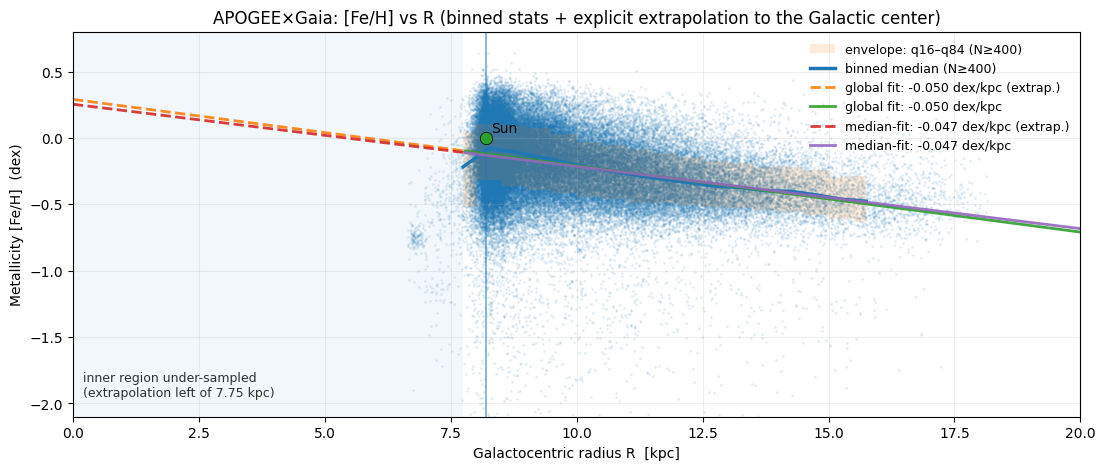

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Settings
# =========================
R_MIN, R_MAX = 0.0, 20.0
R_SUN = 8.2

BIN_W = 0.5                  # kpc
MIN_N_PER_BIN = 400          # как у тебя
EXTRAP_TO_R = 0.0            # до какого R экстраполируем (центр ~0)

# Что экстраполируем:
# 1) global fit (по всем точкам)
# 2) binned median fit (по надежным бинам)
DO_GLOBAL_FIT = True
DO_MEDIAN_FIT = True

# =========================
# Prepare
# =========================
df = df.copy()
df = df.dropna(subset=["R_gal", "feh"])
df = df[(df["R_gal"] >= R_MIN) & (df["R_gal"] <= R_MAX)]
df = df[(df["feh"] >= -2.5) & (df["feh"] <= 1.0)]

R = df["R_gal"].to_numpy()
FeH = df["feh"].to_numpy()

# =========================
# Binned stats (median + q16-q84 + N)
# =========================
bins = np.arange(R_MIN, R_MAX + BIN_W, BIN_W)
cent = 0.5 * (bins[:-1] + bins[1:])

bin_idx = np.digitize(R, bins) - 1
med = np.full(len(cent), np.nan)
q16 = np.full(len(cent), np.nan)
q84 = np.full(len(cent), np.nan)
Nbin = np.zeros(len(cent), dtype=int)

for i in range(len(cent)):
    sel = bin_idx == i
    Nbin[i] = int(sel.sum())
    if Nbin[i] < MIN_N_PER_BIN:
        continue
    vals = FeH[sel]
    med[i] = np.nanmedian(vals)
    q16[i] = np.nanpercentile(vals, 16)
    q84[i] = np.nanpercentile(vals, 84)

ok = np.isfinite(med)

# =========================
# Fits + extrapolation
# =========================
# Domain for drawing
R_draw = np.linspace(R_MIN, R_MAX, 600)

# Extrapolated segment domain: from EXTRAP_TO_R to the first "ok" bin center
if ok.any():
    R_ok_min = cent[ok].min()
else:
    R_ok_min = None

# 1) Global fit on all points (linear)
if DO_GLOBAL_FIT:
    # robust-ish: optional sigma-clip could be added later; keep simple for now
    p_glob = np.polyfit(R, FeH, 1)          # FeH = a R + b
    FeH_glob = np.polyval(p_glob, R_draw)

# 2) Fit to binned medians (linear), using only reliable bins
if DO_MEDIAN_FIT and ok.sum() >= 2:
    p_med = np.polyfit(cent[ok], med[ok], 1)
    FeH_medfit = np.polyval(p_med, R_draw)

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(13, 5))

# scatter (subsample to keep it light)
N_SCAT = min(len(df), 120_000)
samp = df.sample(N_SCAT, random_state=1) if len(df) > N_SCAT else df
ax.scatter(samp["R_gal"], samp["feh"], s=3, alpha=0.15, linewidths=0)

# envelope for binned q16-q84 (only where ok)
ax.fill_between(cent, q16, q84, where=ok, alpha=0.15, step="mid", label="envelope: q16–q84 (N≥400)")

# binned median (solid where ok)
ax.plot(cent[ok], med[ok], lw=2.5, label="binned median (N≥400)")

# Add Sun marker + line
ax.axvline(R_SUN, lw=1.5, alpha=0.5)
ax.scatter([R_SUN], [0.0], s=80, edgecolor="k", linewidth=0.5, zorder=5)  # will recolor below if you want
ax.text(R_SUN + 0.1, 0.02, "Sun", fontsize=10, va="bottom")

# --- extrapolation overlays ---
# Helper to split solid vs dashed segments
def plot_with_extrap(ax, x, y, x_ok_min, label, color=None):
    # solid: x >= x_ok_min; dashed: x < x_ok_min
    solid = x >= x_ok_min
    dashed = ~solid
    if dashed.any():
        ax.plot(x[dashed], y[dashed], lw=2, ls="--", alpha=0.9, color=color, label=label + " (extrap.)")
    if solid.any():
        ax.plot(x[solid], y[solid], lw=2, ls="-", alpha=0.9, color=color, label=label)

if R_ok_min is not None:
    if DO_GLOBAL_FIT:
        plot_with_extrap(ax, R_draw, FeH_glob, R_ok_min, label=f"global fit: {p_glob[0]:+.3f} dex/kpc")

    if DO_MEDIAN_FIT and ok.sum() >= 2:
        plot_with_extrap(ax, R_draw, FeH_medfit, R_ok_min, label=f"median-fit: {p_med[0]:+.3f} dex/kpc")

    # Optional: highlight the under-sampled inner region
    ax.axvspan(0, R_ok_min, alpha=0.06)
    ax.text(0.2, -1.95, f"inner region under-sampled\n(extrapolation left of {R_ok_min:.2f} kpc)",
            fontsize=9, alpha=0.8)

ax.set_xlim(R_MIN, R_MAX)
ax.set_ylim(-2.1, 0.8)

ax.set_xlabel("Galactocentric radius R  [kpc]")
ax.set_ylabel("Metallicity [Fe/H]  (dex)")
ax.set_title("APOGEE×Gaia: [Fe/H] vs R (binned stats + explicit extrapolation to the Galactic center)")
ax.grid(alpha=0.2)
ax.legend(frameon=False, fontsize=9, loc="upper right")

plt.show()

“The present-day radial metallicity gradient inferred from APOGEE×Gaia stars is shallow ($\sim\;-0.05\;\mathrm{dex}\;\mathrm{kpc}^{-1}$), consistent with strong radial mixing.
Chemo-dynamical reconstructions and young tracers indicate that the intrinsic ISM gradient at birth was significantly steeper ($\sim -0.2$ to $-0.3\;\mathrm{dex\;kpc}^{-1}$), implying substantial flattening over Galactic time.”